In [ ]:
import cv2
import numpy as np
import os

from skimage.feature import local_binary_pattern

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

from imblearn.over_sampling import SMOTE

In [2]:
def preprocess_image(img):
    img = cv2.resize(img, (128, 128))
    
    img = cv2.medianBlur(img, 5)

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    gray = cv2.equalizeHist(gray)

    return img, hsv, gray

In [3]:
def extract_features(img, hsv, gray):
    features = []

    # 1. HSV Hue Histogram 
    hist = cv2.calcHist([hsv], [0], None, [32], [0, 180])
    hist = hist.astype("float32")
    hist /= (hist.sum() + 1e-6) 
    features.extend(hist.flatten())

    # 2. Texture (LBP)
    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=10, range=(0,10))
    lbp_hist = lbp_hist.astype("float32")
    lbp_hist /= (lbp_hist.sum() + 1e-6)
    features.extend(lbp_hist)

    # 3. Shape Features (SAFE)
    edges = cv2.Canny(gray, 100, 200)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    area = sum(cv2.contourArea(c) for c in contours)
    perimeter = sum(cv2.arcLength(c, True) for c in contours)

    # Hard safety guards
    area = np.clip(area, 0, 1e5)
    perimeter = np.clip(perimeter, 0, 1e4)

    circularity = (4 * np.pi * area) / (perimeter**2 + 1e-6)

    features.extend([area, perimeter, circularity])

    return np.array(features, dtype=np.float32)

In [4]:
def load_dataset(base_path):
    X, y = [], []

    class_map = {"apples": 0, "tomatoes": 1}

    for cls, label in class_map.items():
        folder = os.path.join(base_path, cls)

        for file in os.listdir(folder):
            img_path = os.path.join(folder, file)
            img = cv2.imread(img_path)

            if img is None:
                continue

            img, hsv, gray = preprocess_image(img)
            features = extract_features(img, hsv, gray)

            X.append(features)
            y.append(label)

    return np.array(X), np.array(y)

In [5]:
X, y = load_dataset("/Users/piyushagarwal/Documents/GitHub/mle-exam/content/cv_dataset/train")
mask = np.isfinite(X).all(axis=1)
X = X[mask]
y = y[mask]

In [6]:
import matplotlib.pyplot as plt

In [7]:
def show_sample_images(base_path, samples=3):
    classes = ["apples", "tomatoes"]

    plt.figure(figsize=(8, 4))

    idx = 1
    for cls in classes:
        folder = os.path.join(base_path, cls)
        images = os.listdir(folder)[:samples]

        for img_name in images:
            img_path = os.path.join(folder, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            plt.subplot(2, samples, idx)
            plt.imshow(img)
            plt.title(cls.capitalize())
            plt.axis("off")
            idx += 1

    plt.suptitle("Apple and Tomato Images", fontsize=14)
    plt.show()

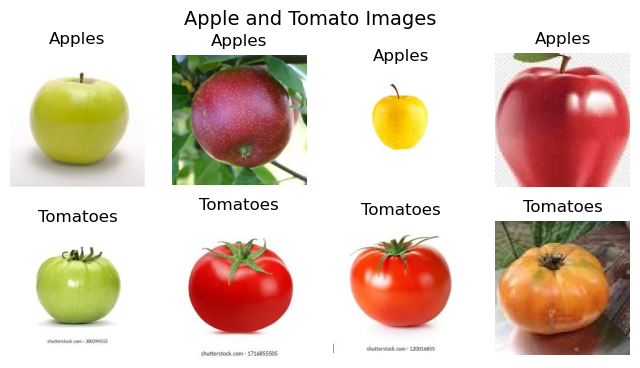

In [8]:
show_sample_images("/Users/piyushagarwal/Documents/GitHub/mle-exam/content/cv_dataset/train", samples=4)

In [9]:
def show_preprocessing_demo(img_path):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img, hsv, gray = preprocess_image(img)
    edges = cv2.Canny(gray, 100, 200)

    plt.figure(figsize=(10, 6))

    plt.subplot(1, 4, 1)
    plt.imshow(img_rgb)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(gray, cmap="gray")
    plt.title("Grayscale + Equalized")
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.imshow(hsv[:,:,0], cmap="hsv")
    plt.title("HSV (Hue Channel)")
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.imshow(edges, cmap="gray")
    plt.title("Edge Detection (Canny)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

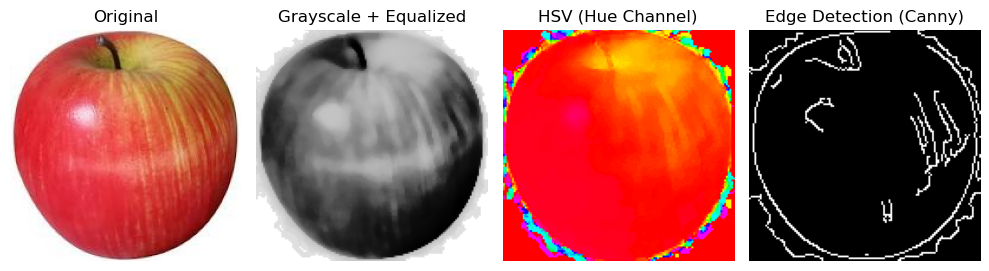

In [10]:
show_preprocessing_demo("/Users/piyushagarwal/Documents/GitHub/mle-exam/content/cv_dataset/train/apples/img_p1_22.jpeg")

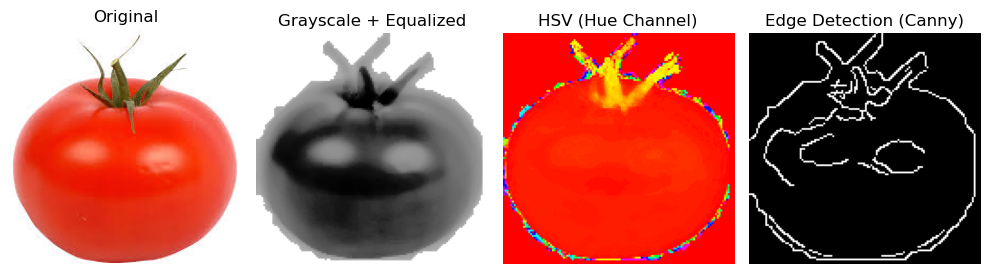

In [11]:
show_preprocessing_demo("/Users/piyushagarwal/Documents/GitHub/mle-exam/content/cv_dataset/train/tomatoes/img_p1_39.jpeg")

In [12]:
def show_contours(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    edges = cv2.Canny(gray, 100, 200)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    contour_img = img.copy()
    cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)

    plt.figure(figsize=(4, 4))
    plt.imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB))
    plt.title("Contour-Based Shape Features")
    plt.axis("off")
    plt.show()

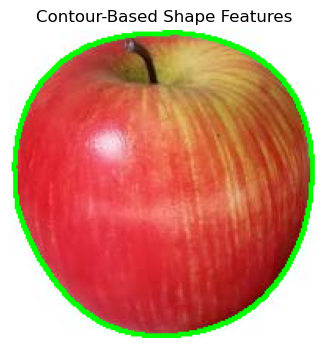

In [13]:
show_contours("/Users/piyushagarwal/Documents/GitHub/mle-exam/content/cv_dataset/train/apples/img_p1_22.jpeg")

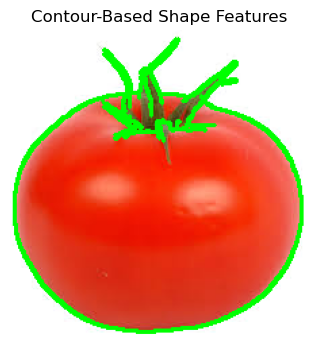

In [14]:
show_contours("/Users/piyushagarwal/Documents/GitHub/mle-exam/content/cv_dataset/train/tomatoes/img_p1_39.jpeg")

In [15]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42,stratify=y_resampled
)

In [51]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import learning_curve

k_values = [3,4,5,6,7,8,9]

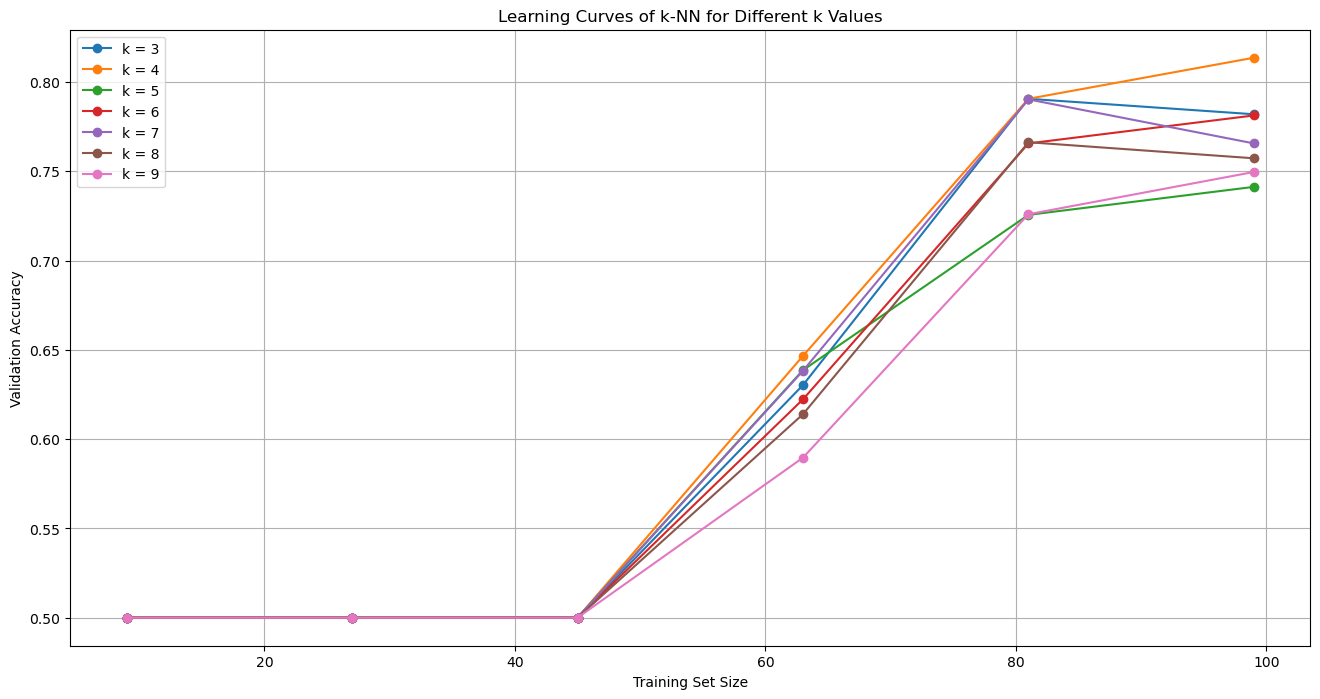

In [53]:
plt.figure(figsize=(16, 8))

for k in k_values:
    knn_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(
            n_neighbors=k,
            weights="distance",
            metric="minkowski"
        ))
    ])

    train_sizes, train_scores, val_scores = learning_curve(
        estimator=knn_pipeline,
        X=X_resampled,
        y=y_resampled,
        train_sizes=np.linspace(0.1, 1.0, 6),
        cv=5,
        scoring="accuracy",
        n_jobs=-1
    )

    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)

    plt.plot(
        train_sizes,
        val_mean,
        marker="o",
        label=f"k = {k}"
    )

plt.xlabel("Training Set Size")
plt.ylabel("Validation Accuracy")
plt.title("Learning Curves of k-NN for Different k Values")
plt.legend()
plt.grid(True)
plt.show()

In [55]:
k = 4

knn_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=k, weights="distance",
            metric="minkowski"))
])
knn_pipeline.fit(X_train, y_train)
y_pred = knn_pipeline.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Apples", "Tomatoes"]))

Confusion Matrix:
[[11  2]
 [ 1 11]]

Classification Report:
              precision    recall  f1-score   support

      Apples       0.92      0.85      0.88        13
    Tomatoes       0.85      0.92      0.88        12

    accuracy                           0.88        25
   macro avg       0.88      0.88      0.88        25
weighted avg       0.88      0.88      0.88        25

